In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import os
import io
import random
import IPython.display
import numpy as np
import PIL.Image
from scipy.stats import truncnorm
import tensorflow_hub as hub

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
tf.reset_default_graph()

# loading the model from tensoflow hub
module_path = 'https://tfhub.dev/deepmind/biggan-deep-256/1'
module = hub.Module(module_path)

In [3]:
inputs = {k: tf.placeholder(v.dtype, v.get_shape().as_list(), k)
          for k, v in module.get_input_info_dict().items()}
output = module(inputs)

print('Inputs:\n' + '\n'.join('  {}: {}'.format(*kv) for kv in inputs.items()))
print('\nOutput:', output)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Inputs:
  y: Tensor("y:0", shape=(?, 1000), dtype=float32)
  z: Tensor("z:0", shape=(?, 128), dtype=float32)
  truncation: Tensor("truncation:0", shape=(), dtype=float32)

Output: Tensor("module_apply_default/G_trunc_output:0", shape=(?, 256, 256, 3), dtype=float32)


In [4]:
input_z = inputs['z']
input_y = inputs['y']
input_trunc = inputs['truncation']

dim_z = input_z.shape.as_list()[1]
vocab_size = input_y.shape.as_list()[1]

def truncated_z_sample(batch_size, truncation=1., seed=None):
  """
  Returns continuous Random variables (rvs) multiplied by a given factor
  Arguments:
    batch_size: Integer, the number of rows in the returned sample
    truncation: Float, the truncation factor, default = 1.
    seed: Integer, the random seed, default = None
  Returns:
    A numpy array of shape [batch_size, dim_z]
  """
  state = None if seed is None else np.random.RandomState(seed)
  values = truncnorm.rvs(-2, 2, size=(batch_size, dim_z), random_state=state)
  return truncation * values

def one_hot(index, vocab_size=vocab_size):
  """
  Ensures index to be a numpy array and returns one-hot encoding of array index
  Arguments:
    index: Integer array
    vocab_size: Integer, size of one-hot encoding features, default = vocab_size
  Returns:
    A 2D numpy array, one-hot encoding of index
  """
  index = np.asarray(index)
  if len(index.shape) == 0:
    index = np.asarray([index])
  assert len(index.shape) == 1

  num = index.shape[0]
  output = np.zeros((num, vocab_size), dtype=np.float32)
  output[np.arange(num), index] = 1
  return output

def one_hot_if_needed(label, vocab_size=vocab_size):
  """
  Checks if label is one-hot encoded (2D in shape), otherwise returns one-hot encoding
  Arguments:
    label: Integer array, labels to check for encoding
    vocab_size: Integer, size of one-hot encoding features, default = vocab_size
  Returns:
    lanel OR A 2D numpy array, one-hot encoding of label
  """
  label = np.asarray(label)
  if len(label.shape) <= 1:
    label = one_hot(label, vocab_size)
  assert len(label.shape) == 2
  return label

def sample(sess, noise, label, truncation=1., batch_size=8, vocab_size=vocab_size):
  """
  Generates and returns an image as a numpy array
  Arguments:
    sess: TensorFlow session
    noise: TensorFlow node, input noise
    label: TensorFlow node, input label
    truncation: Float, truncation factor, default = 1.
    batch_size: Integer, batch size, default = 8
    vocab_size: Integer, size of one-hot encoding features, default = vocab_size
  Returns:
    A numpy array of shape [batch_size, 256, 256, 3]
  """
  noise = np.asarray(noise)
  label = np.asarray(label)
  num = noise.shape[0]

  # ensuring shape of labels and noise are same
  if len(label.shape) == 0:
    label = np.asarray([label] * num)
  if label.shape[0] != num:
    raise ValueError('Got # noise samples ({}) != # label samples ({})'.format(noise.shape[0], label.shape[0]))

  label = one_hot_if_needed(label, vocab_size)
  ims = []
  for batch_start in range(0, num, batch_size):
    # generating image for labels in batches
    s = slice(batch_start, min(num, batch_start + batch_size))
    feed_dict = {input_z: noise[s], input_y: label[s], input_trunc: truncation}
    ims.append(sess.run(output, feed_dict=feed_dict))
  
  # combining output images
  ims = np.concatenate(ims, axis=0)
  assert ims.shape[0] == num
  ims = np.clip(((ims + 1) / 2.0) * 256, 0, 255)
  ims = np.uint8(ims)
  return ims

def imgrid(imarray, cols=5, pad=0):
  """
  Combines a numpy array of images into a grid image with define padding and columns
  Arguments:
    imarray: Numpy array of images
    cols: Integer, number of columns in grid image, default = 5
    pad: Integer, padding between images, default = 0
  Returns:
    A numpy array of shape [rows*height, cols*width, channels]
  """
  if imarray.dtype != np.uint8:
    raise ValueError('imgrid input imarray must be uint8')
    
  pad = int(pad)
  assert pad >= 0
  cols = int(cols)
  assert cols >= 1
  
  # extracting number of images, height,  width, and color channels to set up grid
  N, H, W, C = imarray.shape
  rows = N // cols + int(N % cols != 0)
  batch_pad = rows * cols - N
  assert batch_pad >= 0

  # padding each image to same height and width
  post_pad = [batch_pad, pad, pad, 0]
  pad_arg = [[0, p] for p in post_pad]
  imarray = np.pad(imarray, pad_arg, 'constant', constant_values=255)
  H += pad
  W += pad

  # adding images to the grid
  grid = (imarray.reshape(rows, cols, H, W, C).transpose(0, 2, 1, 3, 4).reshape(rows*H, cols*W, C))
  if pad:
    grid = grid[:-pad, :-pad]
  return grid

def imshow(a, format='png', jpeg_fallback=True):
  """
  Displays the image on the screen, otherwise creates an exception
  Arguments:
    a: Image
    format: String, format of image, default = 'png'
    jpeg_fallback: Boolean, whether to display as JPEG on non-displayable image, default = True
  Returns:
    Returns a handle on updatable displays OR None
  """
  a = np.asarray(a, dtype=np.uint8)
  data = io.BytesIO()
  PIL.Image.fromarray(a).save(data, format)

  # saving the image to a file
  # PIL.Image.fromarray(a).save('nft.{}'.format(format))

  im_data = data.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print(('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format))
      return imshow(a, format='jpeg')
    else:
      raise

  return disp

In [5]:
# starting the session with global variables
initializer = tf.global_variables_initializer()
sess = tf.Session()
sess.run(initializer)

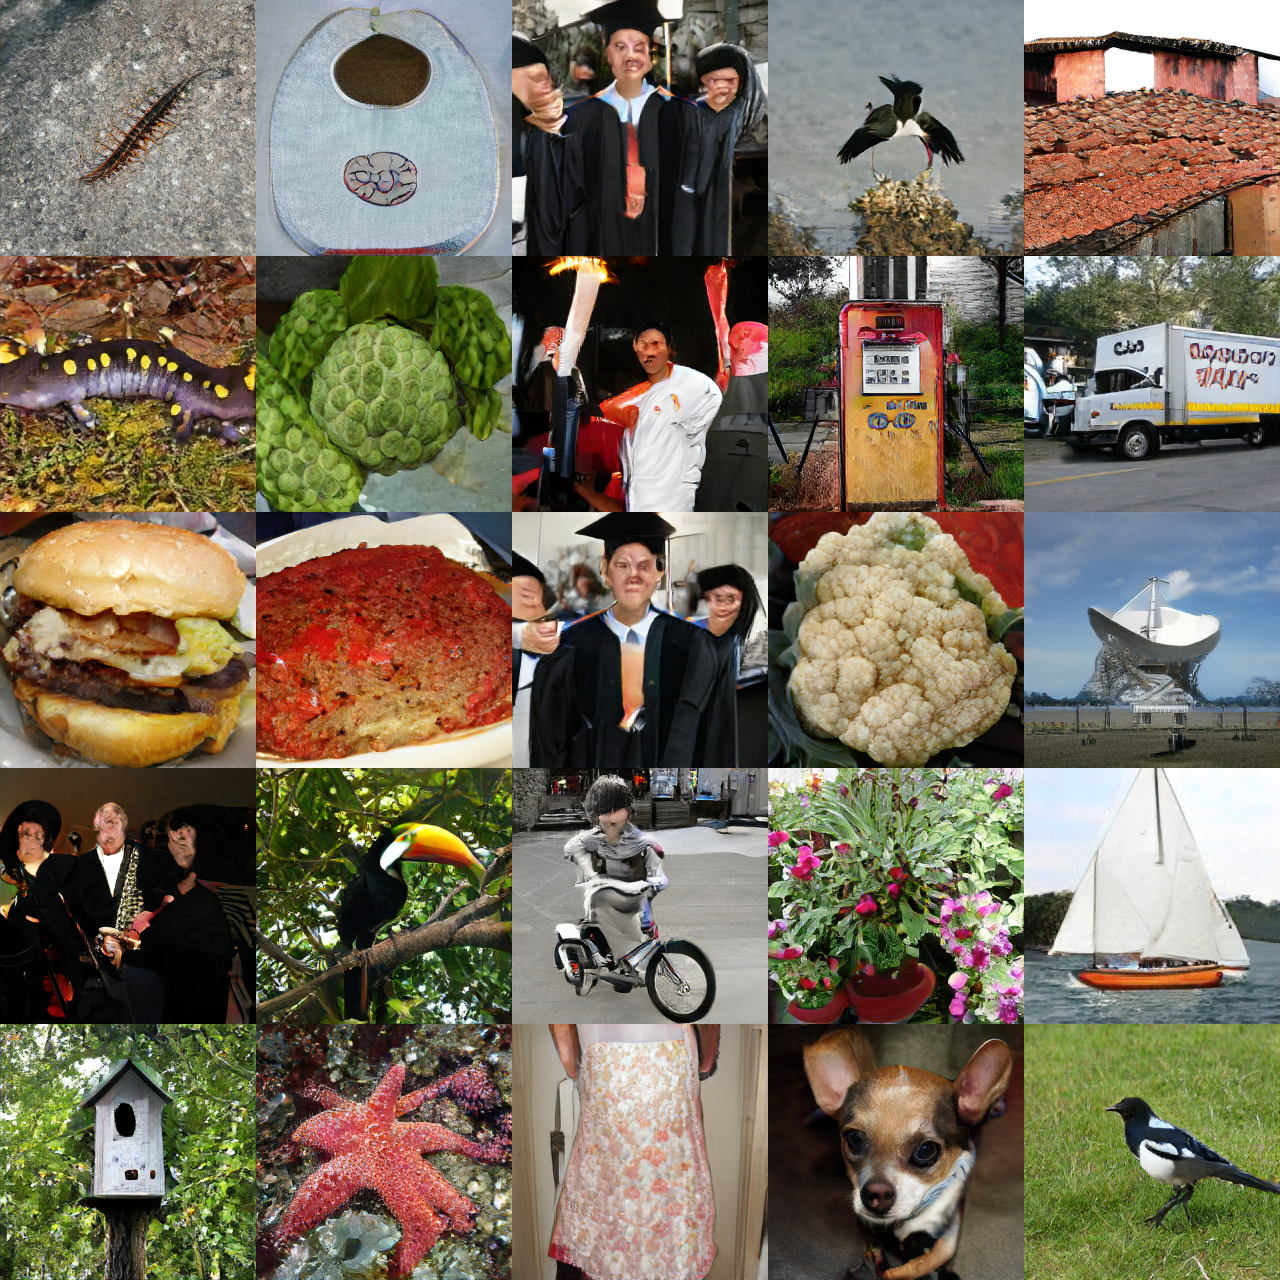

In [6]:
# creating the images
num_samples = 25
truncation = 0.4
noise_seed = 0

z = truncated_z_sample(num_samples, truncation, noise_seed)
y = np.random.randint(1000, size=num_samples)

ims = sample(sess, z, y, truncation=truncation)
imshow(imgrid(ims, cols=min(num_samples, 5)))